# How to generate a lens using _lenstronomy_

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel

from MuSLIT.utils.plot import nice_colorbar

%matplotlib inline

In [2]:
def save_fits(data, file_path, overwrite=True):
    hdu = pf.PrimaryHDU(data)
    hdu.writeto(file_path, overwrite=overwrite)
    print("FITS file successfully saved to", file_path)

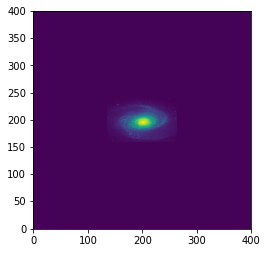

In [3]:
# data from FITS

#psf_path = "tinytim_WFC3_IR_F160W/result00.fits"
#psf_image = pf.open(psf_path)

source_path = "../Data/various_images/M81_HST_prepared_n400.fits"
source_image = pf.open(source_path)[0].data

plt.imshow(source_image, origin='lower')
plt.show()

In [4]:
# data specifics
background_rms = 0.5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
num_pix = 100  # cutout pixel size
delta_pix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
psf_fwhm = 0.1  # full width half max of PSF

delta_pix_source_image = num_pix / len(source_image) * delta_pix

In [5]:
# PSF specification
kwargs_data = sim_util.data_configure_simple(num_pix, delta_pix, exp_time, background_rms, inverse=False)
data_class = ImageData(**kwargs_data)

kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['SPEMD'] #, 'SHEAR']
kwargs_shear = {'e1': 0.01, 'e2': 0.01}  # gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_spemd = {'theta_E': 1., 'gamma': 2., 'center_x': 0, 'center_y': 0, 'e1': 0.2, 'e2': 0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 300., 'R_sersic': 2., 'n_sersic': 2, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
#source_model_list = ['SERSIC_ELLIPSE']
#ra_source, dec_source = 0, 0.1
#kwargs_sersic_ellipse = {'amp': 4000., 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
#                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
#kwargs_source = [kwargs_sersic_ellipse]
#source_model_class = LightModel(light_model_list=source_model_list)

# interpolation from  an image
source_model_list = ['INTERPOL']
ra_source, dec_source = 0.2, 0.3
kwargs_interpol = {'image': source_image, 'amp': 4000., 'scale': delta_pix_source_image, 
                   'phi_G': 0, 'center_x': ra_source, 'center_y': dec_source}
kwargs_source = [kwargs_interpol]
source_model_class = LightModel(light_model_list=source_model_list)

#lensEquationSolver = LensEquationSolver(lens_model_class)
#x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
#                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
#mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
#kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
#                           'point_amp': np.abs(mag)*100}]  # quasar point source position in the source plane and intrinsic brightness
kwargs_ps  = {}
point_source_list = [] #['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list)#, fixed_magnificiation_list=[False])

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

In [6]:
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
noise = bkg + poisson
image_sim = image_sim_no_noise + noise

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

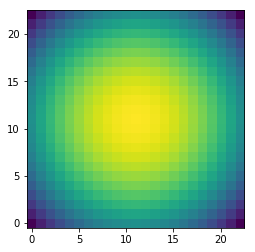

/Users/aymericg/anaconda2/envs/pystro36_lenstro/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


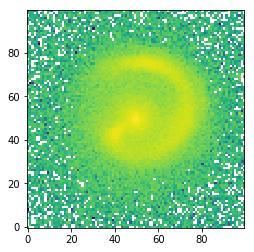

In [7]:
plt.imshow(np.log10(psf_class.kernel_point_source), origin='lower')
plt.show()

plt.imshow(np.log10(image_sim), origin='lower')
plt.show()

In [8]:
# get the source surface brightness only, in source or image plane
image_sim_source_delensed = imageModel.source_surface_brightness(kwargs_source, kwargs_lens=kwargs_lens, 
                                                                 unconvolved=False, de_lensed=True)
image_sim_source_lensed   = imageModel.source_surface_brightness(kwargs_source, kwargs_lens=kwargs_lens, 
                                                                 unconvolved=False, de_lensed=False)

In [9]:
# get the convergence map
x_grid, y_grid = data_class.pixel_coordinates
x_grid1d = lenstro_util.image2array(x_grid)
y_grid1d = lenstro_util.image2array(y_grid)
kappa_result1d = lens_model_class.kappa(x_grid1d, y_grid1d, kwargs_lens)
kappa_result = lenstro_util.array2image(kappa_result1d)

In [10]:
# get the deflection angles
alpha_x1d, alpha_y1d = lens_model_class.alpha(x_grid1d, y_grid1d, kwargs_lens)
alpha_x = lenstro_util.array2image(alpha_x1d)
alpha_y = lenstro_util.array2image(alpha_y1d)
print(alpha_x.shape)
save_fits([alpha_x, alpha_y], 'lensgen_alpha_lenstro.fits')

(100, 100)
FITS file successfully saved to lensgen_alpha_lenstro.fits


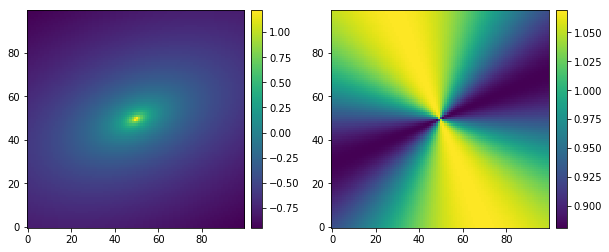

In [15]:
ax = plt.subplot2grid((1, 2), (0, 0), fig=plt.figure(figsize=(10, 4)))
im = ax.imshow(np.log10(kappa_result), origin='lower')
nice_colorbar(im)

ax = plt.subplot2grid((1, 2), (0, 1))
im = ax.imshow(np.sqrt(alpha_x**2+alpha_y**2), origin='lower')
nice_colorbar(im)

plt.show()

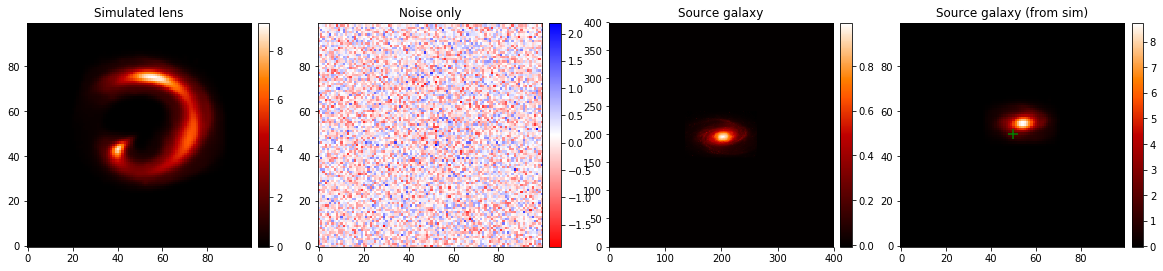

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

ax = axes[0]
ax.set_title("Simulated lens")
im = ax.imshow((image_sim_source_lensed), origin='lower', cmap='gist_heat')
#ax.scatter(numPix/2., numPix/2., color='blue', marker='.', s=40, alpha=0.5) # center of the image
nice_colorbar(im)

ax = axes[1]
ax.set_title("Noise only")
im = ax.imshow(image_sim - image_sim_no_noise, origin='lower', cmap='bwr_r')#, vmin=-0.1, vmax=0.1)
nice_colorbar(im)

ax = axes[2]
ax.set_title("Source galaxy")
im = ax.imshow((source_image), origin='lower', cmap='gist_heat')
nice_colorbar(im)

ax = axes[3]
ax.set_title("Source galaxy (from sim)")
im = ax.imshow((image_sim_source_delensed), origin='lower', cmap='gist_heat')
ax.scatter(num_pix/2., num_pix/2., color='green', marker='+', s=120) # center of the image
nice_colorbar(im)

plt.show()

In [16]:
save_fits(image_sim, 'lensgen_image_noisy_lenstro.fits')
save_fits(image_sim_source_lensed + noise, 'lensgen_source_noisy_lenstro.fits')
save_fits(image_sim_source_delensed, 'lensgen_source_unlensed_lenstro.fits')
save_fits(noise, 'lensgen_noise_lenstro.fits')

FITS file successfully saved to lensgen_image_noisy_lenstro.fits
FITS file successfully saved to lensgen_source_noisy_lenstro.fits
FITS file successfully saved to lensgen_source_unlensed_lenstro.fits
FITS file successfully saved to lensgen_noise_lenstro.fits
